

```
GAN are super sensitive to the paramters
Following
No pooling
Only conv layer, no linear or fully connected hidden layer
Batch norm in both generator and the discriminator
Generator - relu in all layers except the last which has tanh
Discriminator used leaky relu
Weights for zero centered normal distribution
Adam, learning rate=0.002,beta1 = 0.5,beta2 = 0.5
Batch size 128
leaky relu 0.2
```



https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/4_vgg.ipynb#scrollTo=bS8FikHGAO0t

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import time

import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader

In [ ]:
device = ("cuda" if torch.cuda.is_available() else"cpu")
torch.autograd.set_detect_anomaly(True)

In [ ]:
#@title
# class Discriminator(nn.Module):
#     def __init__(self,channel,dis_feature):
#         super(Discriminator,self).__init__()

#         #no batch normalization in the first layer of discriminator
    
#         #Size of the input is Batch * channel * W * H
#         self.disc_network = nn.Sequential(
#                             nn.Sequential(
#                                     nn.Conv2d(channel,dis_feature,kernel_size=4,padding=1,stride=2),  #32
#                                     nn.LeakyReLU(0.2), #slope from the paper implementation
#                                 ),
#                             nn.Sequential(
#                                     nn.Conv2d(dis_feature,dis_feature*2,kernel_size=4,padding=1,stride=2,bias=False), #16
#                                     nn.BatchNorm2d(dis_feature*2),
#                                     nn.LeakyReLU(0.2), #slope from the paper implementation
#                                 ),
#                             nn.Sequential(
#                                     nn.Conv2d(dis_feature*2,dis_feature*4,kernel_size=4,padding=1,stride=2,bias=False),#8
#                                     nn.BatchNorm2d(dis_feature*4),
#                                     nn.LeakyReLU(0.2), #slope from the paper implementation
#                                 ),
#                             nn.Sequential(
#                                     nn.Conv2d(dis_feature*4,dis_feature*8,kernel_size=4,padding=1,stride=2,bias=False),#4
#                                     nn.BatchNorm2d(dis_feature*8),
#                                     nn.LeakyReLU(0.2), #slope from the paper implementation
#                                 ),
#                             nn.Conv2d(dis_feature*8,1,kernel_size=4,padding=0,stride=2), #1*1,
#                             nn.Sigmoid(),   #slope the output should lie between 0 and 1
#                         )
#     def forward(self,x):
#         out = self.disc_network(x)
#         return out


In [ ]:
from torchvision.models import vgg16
vgg16_model = vgg16(pretrained=True)  

for parameter in vgg16_model.features.parameters():
    parameter.requires_grad = False

class VGG(nn.Module):
    def __init__(self, pretrained, output_dim):
        super().__init__()

        #MNIST is a single channel the input to the VGG network must be 3 channels,
        #therefore passing mnist through a cnn with 3 outchannels
        self.conv = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,padding=81)   #addition

        #retaining the structure of the pretrained features

        self.sequential = pretrained.features
        self.avgpool = nn.AdaptiveAvgPool2d(7)

        #modifying the last classification layer
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.LeakyReLU(0.2,inplace = True),
            # nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.LeakyReLU(0.2,inplace = True),
            # nn.Dropout(0.5),
            nn.Linear(512, output_dim),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        x =  self.conv(x)  #addition
        # print(x.shape)
        x = self.sequential(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

dis_model = VGG(vgg16_model, 1).to(device)
# print(dis_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


https://arxiv.org/pdf/1809.01396.pdf

In [ ]:
#@title
# # for child in vgg16.children():
# #     for i,children_of_child in enumerate(child.children()):
# #         if isinstance(children_of_child,(nn.Conv2d)):
            
# for child in list(vgg16.children()):
#     for _,children_of_child in enumerate(list(child.children())):
#         if isinstance(children_of_child,nn.Conv2d):
#             out_features = children_of_child.out_channels
#         if isinstance(children_of_child,nn.ReLU):
#             children_of_child._modules['relu'] = nn.LeakyReLU(0.2)
#         elif isinstance(children_of_child,nn.MaxPool2d):
#             children_of_child._modules['MaxPool2d'] = nn.BatchNorm2d(out_features)


# from torchvision.models import vgg16
# vgg16_model = vgg16(pretrained=True)  

# for parameter in vgg16_model.features.parameters():
#     parameter.requires_grad = False
# for paramter in vgg16_model.features.parameters():
#     print(paramter.requires_grad)
"""
def convert_relu_to_leakyrelu(vgg16_model):
    for child_name, child in vgg16_model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(vgg16_model, child_name, nn.LeakyReLU(0.2))
        else:
            convert_relu_to_leakyrelu(child)

def maxpool_to_batchnorm(vgg16_model,out_channels):
    for child_name, child in vgg16_model.named_children():
        

        if isinstance(child, nn.MaxPool2d):
            setattr(vgg16_model, child_name, nn.BatchNorm2d(out_channels))
        else:
            if isinstance(child,nn.Conv2d):
                out_channels = child.out_channels
            maxpool_to_batchnorm(child,out_channels)
convert_relu_to_leakyrelu(vgg16_model)            
maxpool_to_batchnorm(vgg16_model,64)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
"""
"""
vgg16_model.classifier = nn.Sequential(
                                nn.Linear(vgg16_model.classifier[0].in_features,512),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(512,2),
                                  nn.Sigmoid())
"""
"""
vgg16_model.classifier = nn.Sequential(

nn.Linear(in_features=25088, out_features=4096, bias=True),
nn.LeakyReLU(negative_slope=0.2),
nn.Linear(in_features=4096, out_features=1024, bias=True),
nn.LeakyReLU(negative_slope=0.2),
nn.Linear(in_features=1024, out_features=1, bias=True),
nn.Sigmoid(),
)
"""
# x = torch.randn(1, 3, 224, 224)
# output = vgg16_model(x)
# print(output.shape)

# dis_model = vgg16_model.to(device)
# dis_model

'\nvgg16_model.classifier = nn.Sequential(\n\nnn.Linear(in_features=25088, out_features=4096, bias=True),\nnn.LeakyReLU(negative_slope=0.2),\nnn.Linear(in_features=4096, out_features=1024, bias=True),\nnn.LeakyReLU(negative_slope=0.2),\nnn.Linear(in_features=1024, out_features=1, bias=True),\nnn.Sigmoid(),\n)\n'

In [ ]:
# x = torch.randn(1, 1, 64, 64).to(device)
# output = dis_model(x)
# print(output.reshape(-1))


```
Architecture guidelines for stable Deep Convolutional GANs
1.Replace any pooling layers with strided convolutions (discriminator) and fractional-stridedconvolutions (generator).
2.Use batchnorm in both the generator and the discriminator.
3.Remove fully connected hidden layers for deeper architectures.
4.Use ReLU activation in generator for all layers except for the output, which uses Tanh.
5.Use LeakyReLU activation in the discriminator for all layers.
```

GENERATOR ARCHITECTURE [https://arxiv.org/pdf/1511.06434.pdf]
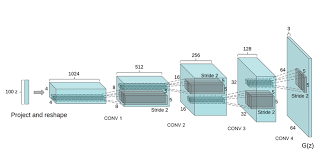

In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_dim,input_dim,gen_feature):
        super(Generator,self).__init__()
        self.gen_network = nn.Sequential(
                            nn.Sequential(
                                #batch size* latent dim * 1*1
                                    nn.ConvTranspose2d(latent_dim,gen_feature*16,kernel_size=4,padding=0,stride=1,bias=False),#batch *gen_featue * 4*4
                                    nn.BatchNorm2d(gen_feature*16),
                                    nn.ReLU(),

                            ),
                            nn.Sequential(
                                
                                nn.ConvTranspose2d(gen_feature*16,gen_feature*8,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 8*8
                                nn.BatchNorm2d(gen_feature*8),
                                nn.ReLU(),

                            ),
                            nn.Sequential(
                                
                                nn.ConvTranspose2d(gen_feature*8,gen_feature*4,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 16*16
                                nn.BatchNorm2d(gen_feature*4),
                                nn.ReLU(),

                            ),
                            nn.Sequential(
                                
                                nn.ConvTranspose2d(gen_feature*4,gen_feature*2,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 32*32
                                nn.BatchNorm2d(gen_feature*2),
                                nn.ReLU(),

                            ),                                                            
                                nn.ConvTranspose2d(gen_feature*2,input_dim,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 64*64
                                nn.Tanh()
                            )   
    def forward(self,x):
        out = self.gen_network(x)
        return out     



INITIALIZE WEIGHTS OF CONV,CONVTRANSPOSE and BATCHNORM

In [ ]:
def initialize_model_weights(nn_model):
    for layer in nn_model.modules():
        if isinstance(layer,(nn.ConvTranspose2d,nn.Conv2d,nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data,0.0,0.02) #paper has zero centerd normal distribution


In [ ]:
#@title
def test():
    N,in_channel,H,W = 8,3,224,224
    z_dim = 100
    x = torch.randn((N,in_channel,H,W)).to(device)
    # disc = Discriminator(in_channel,8)
    # initialize_model_weights(disc)
    print(dis_model(x).shape)
    assert dis_model(x).shape == (N,1)

    z = torch.randn((N,z_dim,1,1)).to(device)
    gen = Generator(z_dim,in_channel,8)
    initialize_model_weights(gen)
    print(gen(z).shape)
    assert gen(z).shape == (N,in_channel,H,W)

In [ ]:
learning_rate = 0.0002
batch_size = 32
img_size = 64
channels = 1
n_epochs = 10
latent_dim = 100
noise_latent_dim = 100
dis_feature = 64
gen_feature = 64

lambda_ = 10
critic_iter = 5   #as i am using wassertien loss
weight_clip = 0.01


In [ ]:
transformations = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  #subtraction
    transforms.Normalize([0.5]*channels,[0.5]*channels),
])

data = datasets.MNIST(root="./data",download=True,train=True,transform=transformations,)
loader =  DataLoader(data,shuffle=True, batch_size = batch_size)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


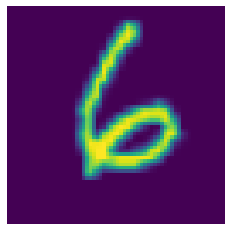

In [ ]:
"""
3 channel
for data,_ in loader:
    plt.imshow((data[0]*0.5+0.5).permute(1,2,0))
    break
plt.axis("off")
plt.show()
"""

#1 channel

for data,_ in loader:
    plt.imshow((data[0]*0.5+0.5).reshape(64,64))
    break
plt.axis("off")
plt.show()

In [ ]:
gen_model = Generator(latent_dim,channels,gen_feature).to(device)
# dis_model = Discriminator(channels,dis_feature).to(device)

In [ ]:
initialize_model_weights(gen_model)
initialize_model_weights(dis_model)

In [ ]:
gen_optimizer = optim.Adam(gen_model.parameters(),lr=learning_rate, betas=(0.5,0.9)) #authors of the paper use 0.5 for beta1
dis_optimizer = optim.Adam(dis_model.parameters(),lr=learning_rate, betas=(0.5,0.9))

https://github.com/soumith/ganhacks/issues/36

I was facing the issue where the loss of discriminator would go to 0. I have therefore removed sigmoid from the final layer of the classifer and used a BCE logit loss.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Epoch 0/10 Batch: 0/1875                    Disciminator Loss 0.6931559443473816                    Generator Loss 0.0021266955882310867
Epoch 0/10 Batch: 100/1875                    Disciminator Loss 0.6932843327522278                    Generator Loss 0.7026586532592773
Epoch 0/10 Batch: 200/1875                    Disciminator Loss 0.7147901654243469                    Generator Loss 0.9635376334190369
Epoch 0/10 Batch: 300/1875                    Disciminator Loss 0.7145811915397644                    Generator Loss 0.7915351390838623
Epoch 0/10 Batch: 400/1875                    Disciminator Loss 0.6931474804878235                    Generator Loss 0.6944644451141357
Epoch 0/10 Batch: 500/1875                    Disciminator Loss 0.6931471824645996                    Generator Loss 0.6934542655944824
Epoch 0/10 Batch: 600/1875                    Disciminator Loss 0.7742630243301392                    Generator Loss 1.148956298828125
Epoch 0/10 Batch: 700/1875                    Di

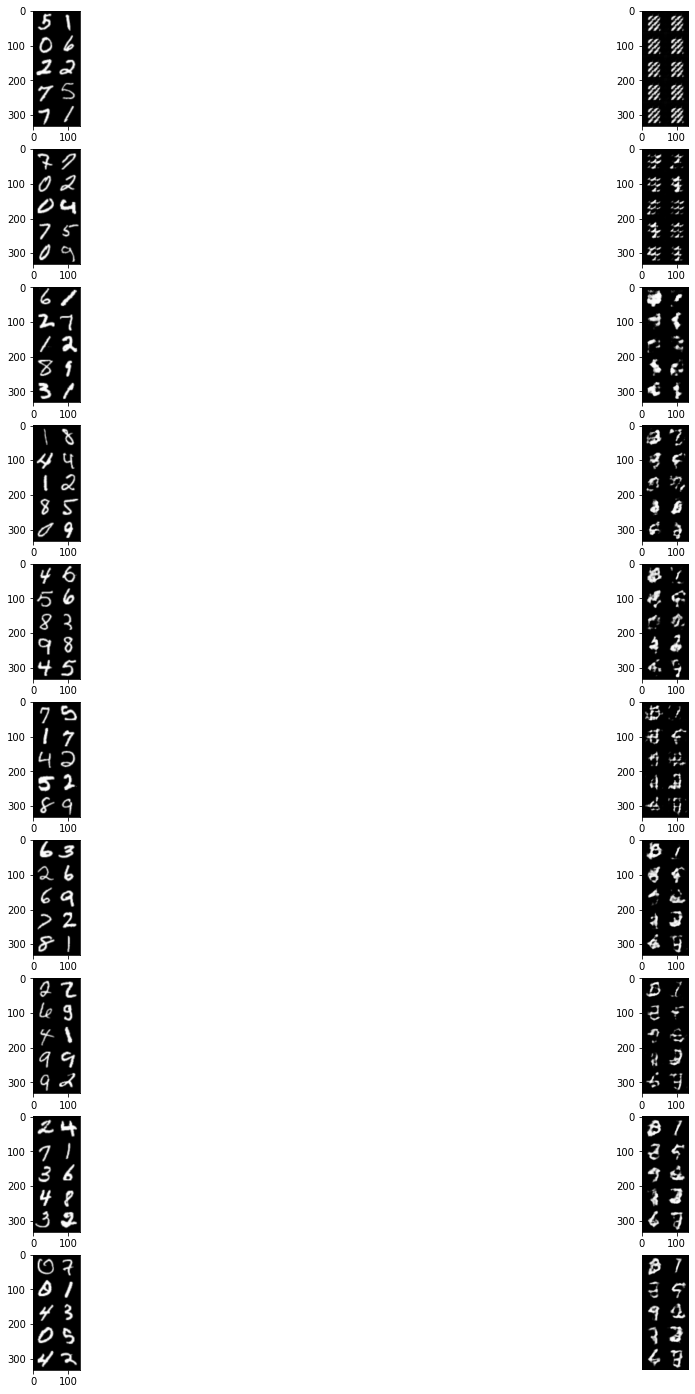

In [ ]:
step=0
noise = torch.randn(32,latent_dim,1,1).to(device)

fig,axes = plt.subplots(n_epochs,2,figsize=(20,25))
plt.axis('off')
training_history = {}
training_history['D_losses'] = []
training_history['G_losses'] = []
training_history['per_epoch_times'] = []
training_history['total_time'] = []


gen_model.train()
dis_model.train()
start = time.time()
for epoch in range(n_epochs):
    dis_losses = []
    gen_losses = []
    start_time = time.time()
    for batch_id, (real_img,_) in enumerate(loader):
        
        real_img = real_img.to(device)
        random_noise = torch.randn(batch_size,latent_dim,1,1).to(device)
        fake_img = gen_model(random_noise)
        #train discriminator first
        #maximize the score(real)+score(1-fake)
        dis_real_out = dis_model(real_img).reshape(-1) #only one value across all the batch for every example
        dis_real_loss = criterion(dis_real_out,torch.ones_like(dis_real_out))
        dis_fake_out = dis_model(fake_img).reshape(-1) #only one value across all the batch for every example
        dis_fake_loss = criterion(dis_fake_out,torch.zeros_like(dis_fake_out))

        dis_loss = (dis_real_loss + dis_fake_loss)/2
        dis_model.zero_grad()
        dis_loss.backward(retain_graph=True) #we need to use the fake again 
        
        dis_optimizer.step()
        #train generator
        #maximize score(real wrt d)
        gen_output = dis_model(fake_img).reshape(-1)
        gen_loss = criterion(gen_output,torch.ones_like(gen_output))
        gen_model.zero_grad()
        gen_loss.backward()

        
        gen_optimizer.step()
        
        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

        if batch_id %100 == 0:
            print(f"Epoch {epoch}/{n_epochs} Batch: {batch_id}/{len(loader)}\
                    Disciminator Loss {dis_loss}\
                    Generator Loss {gen_loss}")
        
    with torch.no_grad():
        fake = gen_model(noise)
        # print(fake.shape)
        # print(real_img.shape)
        grid_real = torchvision.utils.make_grid(real_img[:10],nrow=2,normalize=True)
        grid_fake = torchvision.utils.make_grid(fake[:10],nrow=2,normalize=True)
        axes[epoch][0].imshow(grid_real.permute((1, 2, 0)).cpu())
        axes[epoch][1].imshow(grid_fake.permute((1, 2, 0)).cpu())
        # real_logs.add_image("Real",grid_real,global_step=step)
        # fake_logs.add_image("Fake",grid_fake,global_step=step)
    # step= step+1
    end_time = time.time()
    per_epoch_time = end_time - start_time
    
    training_history['D_losses'].append(torch.mean(torch.FloatTensor(dis_losses)))
    training_history['G_losses'].append(torch.mean(torch.FloatTensor(gen_losses)))
    training_history['per_epoch_times'].append(per_epoch_time)

end = time.time()
total_time = end - start
training_history['total_time'].append(total_time)
plt.show()

In [ ]:
with torch.no_grad():
    fake = gen_model(noise)
    # print(fake.shape)
    # print(real_img.shape)
    grid_real = torchvision.utils.make_grid(real_img[:10],nrow=2,normalize=True)
    grid_fake = torchvision.utils.make_grid(fake[:10],nrow=2,normalize=True)
    axes[epoch][0].imshow(grid_real.permute((1, 2, 0)).cpu())
    axes[epoch][0].axis("off")
    axes[epoch][1].imshow(grid_fake.permute((1, 2, 0)).cpu())
    axes[epoch][1].axis("off")
plt.show()

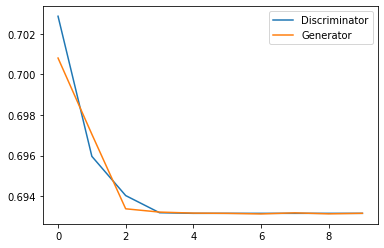

In [ ]:
plt.plot(training_history['D_losses'],label="Discriminator")
plt.plot(training_history['G_losses'],label="Generator")
plt.legend()
plt.show()

# **CONTROLLING THE OUPTUTS GENERATED WITH CONDITIONAL GAN**

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self,channel,dis_feature,num_classes, img_size):
        super(ConditionalDiscriminator,self).__init__()

        #no batch normalization in the first layer of discriminator
    
        #Size of the input is Batch * channel * W * H
        self.img_size = img_size
        self.disc_network = nn.Sequential(
                            nn.Sequential(
                                    nn.Conv2d(channel+1,dis_feature,kernel_size=4,padding=1,stride=2),  #32
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Sequential(
                                    nn.Conv2d(dis_feature,dis_feature*2,kernel_size=4,padding=1,stride=2,bias=False), #16
                                    nn.BatchNorm2d(dis_feature*2),
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Sequential(
                                    nn.Conv2d(dis_feature*2,dis_feature*4,kernel_size=4,padding=1,stride=2,bias=False),#8
                                    nn.BatchNorm2d(dis_feature*4),
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Sequential(
                                    nn.Conv2d(dis_feature*4,dis_feature*8,kernel_size=4,padding=1,stride=2,bias=False),#4
                                    nn.BatchNorm2d(dis_feature*8),
                                    nn.LeakyReLU(0.2), #slope from the paper implementation
                                ),
                            nn.Conv2d(dis_feature*8,1,kernel_size=4,padding=0,stride=2), #1*1,
                            nn.Sigmoid(),   #slope the output should lie between 0 and 1
                        )
        self.embedding = nn.Embedding(num_classes,img_size*img_size)
    def forward(self,x,y):
        #adding an additional channel of size H,W
        # print("Forward pass")
        embedding = self.embedding(y)
        # print(embedding.shape)
        embedding = embedding.view(y.shape[0],1, self.img_size,self.img_size)
        x =  torch.cat([x,embedding],dim=1)# Batch size, channels, H,W
        # print(x.shape)
        out = self.disc_network(x)
        return out


In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self,latent_dim,input_dim,gen_feature,num_classes,img_size,embed_size):
        super(ConditionalGenerator,self).__init__()
        self.img_size = img_size
        self.embedding = nn.Embedding(num_classes,embed_size)
        self.gen_network = nn.Sequential(
                            nn.Sequential(
                                #batch size* latent dim * 1*1
                                    nn.ConvTranspose2d(latent_dim+embed_size,gen_feature*16,kernel_size=4,padding=0,stride=1,bias=False),#batch *gen_featue * 4*4
                                    nn.BatchNorm2d(gen_feature*16),
                                    nn.ReLU(),

                            ),
                            nn.Sequential(
                                
                                nn.ConvTranspose2d(gen_feature*16,gen_feature*8,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 8*8
                                nn.BatchNorm2d(gen_feature*8),
                                nn.ReLU(),

                            ),
                            nn.Sequential(
                                
                                nn.ConvTranspose2d(gen_feature*8,gen_feature*4,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 16*16
                                nn.BatchNorm2d(gen_feature*4),
                                nn.ReLU(),

                            ),
                            nn.Sequential(
                                
                                nn.ConvTranspose2d(gen_feature*4,gen_feature*2,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 32*32
                                nn.BatchNorm2d(gen_feature*2),
                                nn.ReLU(),

                            ),                                                            
                                nn.ConvTranspose2d(gen_feature*2,input_dim,kernel_size=4,padding=1,stride=2,bias=False),#batch *gen_featue * 64*64
                                nn.Tanh()
                            )   
    def forward(self,x,y):
        #batch size, latent dim, 1,1
        embedding = self.embedding(y)
        # print(x.shape,embedding.shape)
        # print(embedding.unsqueeze(2))
        # print(embedding.unsqueeze(2).unsqueeze(3))
        embedding = embedding.unsqueeze(2).unsqueeze(3)  #now embedding will have 1*1 in the end
        # print(x.shape,embedding.shape)
        x =  torch.cat([x,embedding],dim=1)
        out = self.gen_network(x)
        return out     

def initialize_model_weights(nn_model):
    for layer in nn_model.modules():
        if isinstance(layer,(nn.ConvTranspose2d,nn.Conv2d,nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data,0.0,0.02) #paper has zero centerd normal distribution



In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
learning_rate = 0.0002
batch_size = 128
img_size = 64
channels = 1 #mnist
latent_dim = 100
dis_feature = 64
gen_feature = 64

num_classes = 10
embed_size = 100
n_epochs = 10

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  #subtraction
    transforms.Normalize([0.5]*channels,[0.5]*channels),
])

data = datasets.MNIST(root="./data",download=True,train=True,transform=transformations,)
loader =  DataLoader(data,shuffle=True, batch_size = batch_size)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
cgen_model = ConditionalGenerator(latent_dim,channels,gen_feature,num_classes,img_size,embed_size).to(device)
cdis_model = ConditionalDiscriminator(channels,dis_feature,num_classes, img_size).to(device)


initialize_model_weights(cgen_model)
initialize_model_weights(cdis_model)


cgen_optimizer = optim.Adam(cgen_model.parameters(),lr=learning_rate, betas=(0.5,0.9)) #authors of the paper use 0.5 for beta1
cdis_optimizer = optim.Adam(cdis_model.parameters(),lr=learning_rate, betas=(0.5,0.9))


cgan_criterion = nn.BCELoss()
# cgan_criterion = nn.BCEWithLogitsLoss()


In [ ]:
import time

Epoch 0/10 Batch: 0/469                    Disciminator Loss 0.6958874464035034                    Generator Loss 0.7104582786560059
Epoch 0/10 Batch: 100/469                    Disciminator Loss 0.0028731664642691612                    Generator Loss 5.9856648445129395
Epoch 0/10 Batch: 200/469                    Disciminator Loss 2.5168885258608498e-05                    Generator Loss 10.69111442565918
Epoch 0/10 Batch: 300/469                    Disciminator Loss 0.00029490087763406336                    Generator Loss 7.9232025146484375
Epoch 0/10 Batch: 400/469                    Disciminator Loss 0.21997693181037903                    Generator Loss 1.337742567062378
Epoch 1/10 Batch: 0/469                    Disciminator Loss 0.5606915950775146                    Generator Loss 0.8418432474136353
Epoch 1/10 Batch: 100/469                    Disciminator Loss 0.6267780065536499                    Generator Loss 0.5475372076034546
Epoch 1/10 Batch: 200/469                    Disc

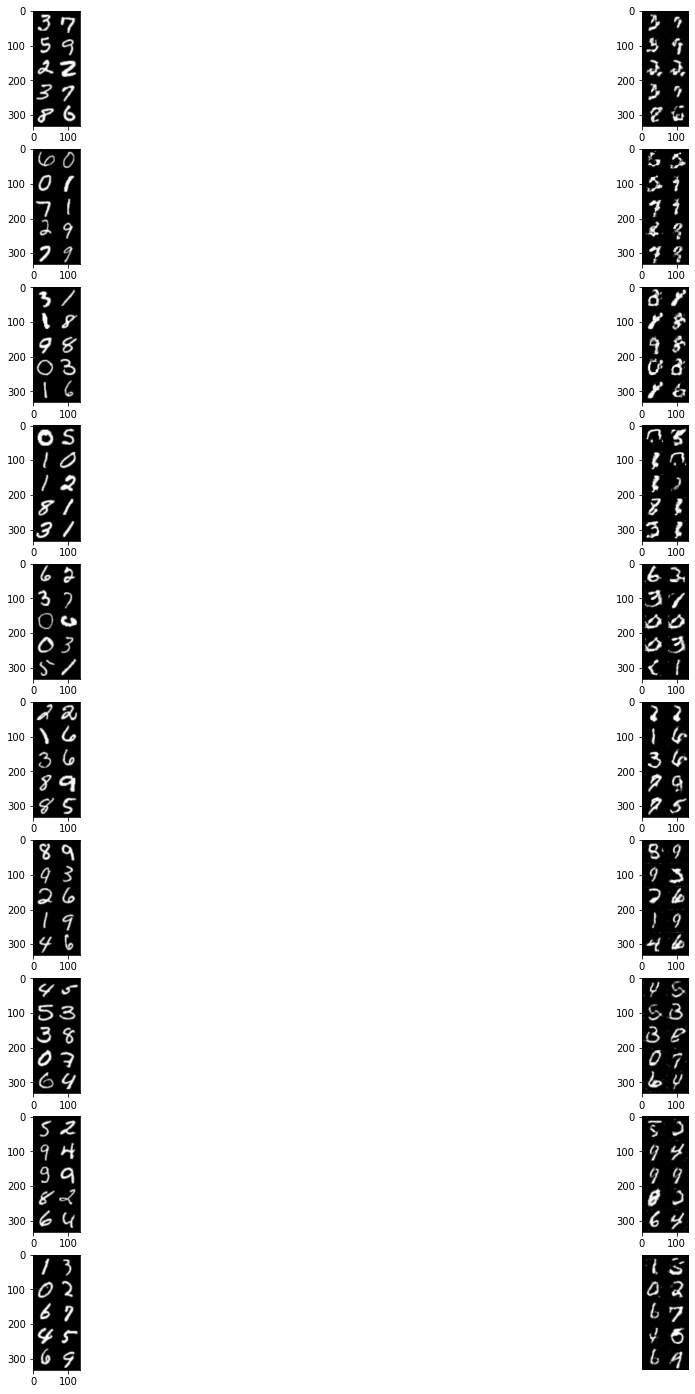

In [ ]:
step=0
fig,axes = plt.subplots(n_epochs,2,figsize=(20,25))
plt.axis('off')

ctraining_history = {}
ctraining_history['D_losses'] = []
ctraining_history['G_losses'] = []
ctraining_history['per_epoch_times'] = []
ctraining_history['total_time'] = []


cgen_model.train()
cdis_model.train()
start = time.time()
for epoch in range(n_epochs):
    dis_losses = []
    gen_losses = []
    start_time = time.time()
    for batch_id, (real_img,label) in enumerate(loader):
        
        real_img = real_img.to(device)
        label = label.to(device)
        random_noise = torch.randn(real_img.size(0),latent_dim,1,1).to(device)
        fake_img = cgen_model(random_noise,label)
        #train discriminator first
        #maximize the score(real)+score(1-fake)
        dis_real_out = cdis_model(real_img,label).reshape(-1) #only one value across all the batch for every example
        dis_real_loss = cgan_criterion(dis_real_out,torch.ones_like(dis_real_out))
        dis_fake_out = cdis_model(fake_img,label).reshape(-1) #only one value across all the batch for every example
        dis_fake_loss = cgan_criterion(dis_fake_out,torch.zeros_like(dis_fake_out))

        dis_loss = (dis_real_loss + dis_fake_loss)/2
        cdis_model.zero_grad()
        dis_loss.backward(retain_graph=True) #we need to use the fake again 
        
        cdis_optimizer.step()
        #train generator
        #maximize score(real wrt d)
        gen_output = cdis_model(fake_img,label).reshape(-1)
        gen_loss = cgan_criterion(gen_output,torch.ones_like(gen_output))
        cgen_model.zero_grad()
        gen_loss.backward()

        
        cgen_optimizer.step()
        
        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

        if batch_id %100 == 0:
            print(f"Epoch {epoch}/{n_epochs} Batch: {batch_id}/{len(loader)}\
                    Disciminator Loss {dis_loss}\
                    Generator Loss {gen_loss}")
        
    with torch.no_grad():
        test_noise = torch.randn(label.size(0),latent_dim,1,1).to(device)
        fake = cgen_model(test_noise,label)
        # print(fake.shape)
        # print(real_img.shape)
        grid_real = torchvision.utils.make_grid(real_img[:10],nrow=2,normalize=True)
        grid_fake = torchvision.utils.make_grid(fake[:10],nrow=2,normalize=True)
        axes[epoch][0].imshow(grid_real.permute((1, 2, 0)).cpu())
        axes[epoch][1].imshow(grid_fake.permute((1, 2, 0)).cpu())
        # real_logs.add_image("Real",grid_real,global_step=step)
        # fake_logs.add_image("Fake",grid_fake,global_step=step)
    # step= step+1
    end_time = time.time()
    per_epoch_time = end_time - start_time
    
    ctraining_history['D_losses'].append(torch.mean(torch.FloatTensor(dis_losses)))
    ctraining_history['G_losses'].append(torch.mean(torch.FloatTensor(gen_losses)))
    ctraining_history['per_epoch_times'].append(per_epoch_time)

end = time.time()
total_time = end - start
ctraining_history['total_time'].append(total_time)
plt.show()

In [ ]:
with torch.no_grad():
    test_noise = torch.randn(label.size(0),latent_dim,1,1).to(device)
    fake = cgen_model(test_noise,label)
    # print(fake.shape)
    # print(real_img.shape)
    grid_real = torchvision.utils.make_grid(real_img[:10],nrow=2,normalize=True)
    grid_fake = torchvision.utils.make_grid(fake[:10],nrow=2,normalize=True)
    axes[epoch][0].imshow(grid_real.permute((1, 2, 0)).cpu())
    axes[epoch][1].imshow(grid_fake.permute((1, 2, 0)).cpu())
    axes[epoch][0].axis('off')
    axes[epoch][1].axis("off")
plt.show()

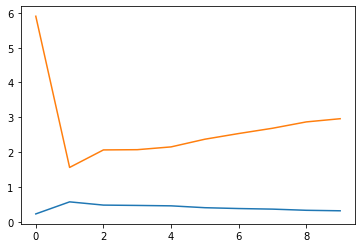

In [ ]:
plt.plot(ctraining_history['D_losses'])
plt.plot(ctraining_history['G_losses'])